# Imports

In [1]:
# pip install statsforecast
# conda install -c conda-forge prophet
# pip install lightgbm
# pip install xgboost

In [2]:
# Import bibliotecas básicas
import numpy as np
from numpy import mean
from scipy import stats
import pandas as pd
from datetime import date, time, datetime, timedelta

# Import bibliotecas de visualização e manipulação
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go


# Imports Statsmodel ans Statsforecast
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, AutoETS, HoltWinters

# Imports Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation # validação de métricas
from prophet.diagnostics import performance_metrics # validação de métricas


from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

# Import XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid", palette="pastel")

c:\Users\Barbara\anaconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Helper Functions

Função para ajustar valores

In [3]:
def correct_value_with_separators(row):
    value = row['Preco']
    before_dot = str(value)[:-2]
    after_dot = str(value)[-2:]
    new_value = before_dot + "." + after_dot
    return new_value

Função para mapear dias de semana

In [4]:
dias_da_semana = {
    0: "Segunda-Feira",
    1: "Terça-Feira",
    2: "Quarta-Feira",
    3: "Quinta-Feira",
    4: "Sexta-Feira",
    5: "Sábado",
    6: "Domingo"
}

Função para criar date features para XGBoost

In [5]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week  
    return df

Função para criação de médias móveis no dataframe principal

In [153]:
def calculate_moving_averages(df, target, windows): #adicionar colunas de média móvel ao dataframe para modelo
    for window in windows:
        ma_col_name = f'{target}_ma_{window}'
        df[ma_col_name] = df[target].rolling(window=window).mean() #.dropna()
        
    df.dropna(inplace=True)
    return df


# função de calculo para previsões futuras

def calculate_moving_averages_all(df, target, windows): #adicionar colunas de média móvel ao dataframe para modelo
    for window in windows:
        ma_col_name = f'{target}_ma_{window}'
        df[ma_col_name] = df[target].rolling(window=window).mean() #.dropna()

    # inserindo a média dos dados móveis dos ultimos dias com valore conhecido no modelo
    for ma in [f'{target}_ma_{window}' for window in windows]:
        df[ma].fillna(method='ffill', inplace=True)

    return df

Concatenação dos datasets de treino e teste

In [7]:
index_test = None

def agg_datasets_train_test(df, y_train, y_test, prediction):
    global index_test 
    index_train = df.index[:len(y_train)]
    index_test = df.index[len(y_train):len(y_train) + len(y_test)]
    
    # Criando DataFrames para os conjuntos de treino, teste e previsão
    df_train = pd.DataFrame({'y_train': y_train}, index=index_train)
    df_test = pd.DataFrame({'y_test': y_test}, index=index_test)
    df_predict = pd.DataFrame({'predict': prediction}, index=index_test)
    return df_train, df_test, df_predict


Criação de uma lista global para armazenar resultados das métricas dos diferentes modelos executados

In [8]:
# Lista global para armazenar os resultados
evaluation_results = {
    'MAE': {},
    'MSE': {},
    'MAPE': {},
    'R2': {}
}

Função para validação de modelos e plot de gráfico

In [9]:
def evaluate_model(y_test, prediction, modelo):
  mae = mean_absolute_error(y_test, prediction)
  mse = mean_squared_error(y_test, prediction)
  mape = mean_absolute_percentage_error(y_test, prediction)
  r2 = r2_score(y_test, prediction)
  
  # Adiciona os resultados ao dicionário de métricas
  evaluation_results['MAE'][modelo] = mae
  evaluation_results['MSE'][modelo] = mse
  evaluation_results['MAPE'][modelo] = mape
  evaluation_results['R2'][modelo] = r2

  print(f"Métricas de avaliação {modelo}:")
  print(f"\tMAE: {mean_absolute_error(y_test, prediction)}")
  print(f"\tMSE: {mean_squared_error(y_test, prediction)}")
  print(f"\tMAPE: {mean_absolute_percentage_error(y_test, prediction):.2f}%")
  print(f"\tR2 Score: {r2_score(y_test, prediction):.2f}%")

  
def evaluate_model_grid(y_test, prediction, modelo):
  mae = mean_absolute_error(y_test, prediction)
  mse = mean_squared_error(y_test, prediction)
  mape = mean_absolute_percentage_error(y_test, prediction)
  r2 = r2_score(y_test, prediction)
  
  # Adiciona os resultados ao dicionário de métricas
  evaluation_results['MAE'][modelo] = mae
  evaluation_results['MSE'][modelo] = mse
  evaluation_results['MAPE'][modelo] = mape
  evaluation_results['R2'][modelo] = r2
  
  print(f"Métricas de avaliação {modelo}:")
  print(f"\tMAE: {mean_absolute_error(y_test, prediction)}")
  print(f"\tMSE: {mean_squared_error(y_test, prediction)}")
  print(f"\tMAPE: {mean_absolute_percentage_error(y_test, prediction):.2f}%")
  print(f"\tR2 Score: {r2_score(y_test, prediction):.2f}%")
  print("Melhores parâmetros:")
  print(f"\tMelhores hiperparâmetros encontrados: {grid_search.best_params_}")
  print(f"\tMelhor pontuação: {grid_search.best_score_:.2f}%")

Função para plotar gráficos de avalicação

In [10]:
# plot predição geral
def plot_predictions_grid(x_test, y_test, prediction, modelo):
  df_test = pd.DataFrame({"date": x_test, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.title(f'Performance dados reais x preditos {modelo}')
  plt.legend(["Actual", "Prediction"])
  plt.show()
  
 
# gráfico plot dados teste 
def plot_prediction_test(df_train, df_test, df_predict, modelo):
  plt.figure(figsize=(15, 6))
  plt.plot(df_train['y_train'], label='Treino')
  plt.plot(df_test['y_test'], label='Teste', linewidth=2, color = "gray")  # Linha mais grossa
  plt.plot(df_predict['predict'], label='Previsão', linewidth=0.3,color='red', linestyle='--')  # Linha pontilhada
  plt.title(f'Comparação entre Treino, Teste e Previsão {modelo}')
  plt.xlabel('Data')
  plt.ylabel('Preço')
  plt.legend()
  plt.show()
  
  
# gráfico avalicação de resíduos
def plot_residuos(y_test, prediction, modelo):
  residuos = y_test - prediction
  df_residuos = pd.DataFrame({'residuos': residuos}, index=index_test)  # Criando DataFrame para os resíduos
  plt.figure(figsize=(15, 6))
  plt.plot(df_residuos['residuos'], label='Resíduos', linestyle='-', color='blue')
  plt.title(f'Análise dos Resíduos - {modelo}')
  plt.xlabel('Data')
  plt.ylabel('Resíduos')
  plt.axhline(y=0, color='r', linestyle='--')  # Linha horizontal em y=0
  plt.legend()
  plt.show()

## Database

In [11]:
ipeadata = pd.read_html(r"http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view", encoding='utf-8', header=0)[2]
ipeadata.head()

,Data,Preço - petróleo bruto - Brent (FOB)
0,16/01/2024,8015
1,15/01/2024,7976
2,12/01/2024,7989
3,11/01/2024,8021
4,10/01/2024,7846


## Renomeando as Colunas

In [12]:
ipeadata.columns = ['Data', 'Preco']

## Alterando os tipos das variáveis

In [13]:
ipeadata['Data'] = pd.to_datetime(ipeadata['Data'], format='%d/%m/%Y')
ipeadata.Preco = ipeadata.apply(lambda row: correct_value_with_separators(row), axis=1)
ipeadata.Preco = ipeadata.Preco.astype(float)
ipeadata.head()

,Data,Preco
0,2024-01-16,80.15
1,2024-01-15,79.76
2,2024-01-12,79.89
3,2024-01-11,80.21
4,2024-01-10,78.46


## Transformação dos Dados

In [14]:
ipeadata['Dia da semana'] = ipeadata.Data.dt.dayofweek
ipeadata['Dia da semana'] = ipeadata['Dia da semana'].map(dias_da_semana)
ipeadata.head()

,Data,Preco,Dia da semana
0,2024-01-16,80.15,Terça-Feira
1,2024-01-15,79.76,Segunda-Feira
2,2024-01-12,79.89,Sexta-Feira
3,2024-01-11,80.21,Quinta-Feira
4,2024-01-10,78.46,Quarta-Feira


In [15]:
print(f"Média: {round(np.average(ipeadata['Preco']), 2)}")
print(f"Moda: {stats.mode(ipeadata['Preco'])[0]}")
print(f"Mediana: {np.median(ipeadata['Preco'])}")

Média: 52.79
Moda: 18.48
Mediana: 47.88


## Análise do Seasonal Decompose

In [16]:
resultado_seasonal_decompose = seasonal_decompose(ipeadata[['Preco']], period=12, model='multiplicative')

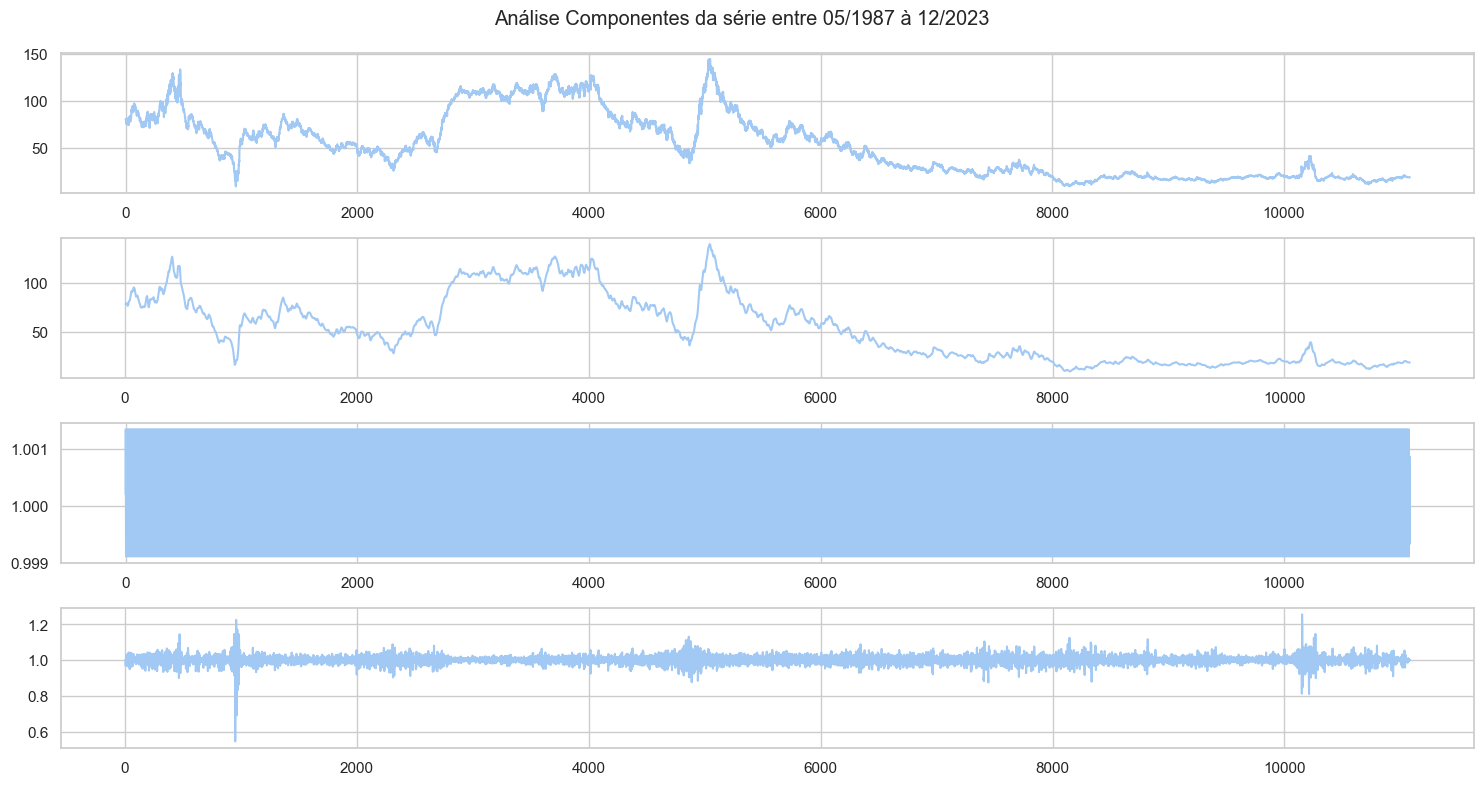

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,8))
plt.suptitle("Análise Componentes da série entre 05/1987 à 12/2023")
resultado_seasonal_decompose.observed.plot(ax=ax1) # observação dos gráficos ao longo do tempo
resultado_seasonal_decompose.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultado_seasonal_decompose.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultado_seasonal_decompose.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

In [18]:
resultado_seasonal_decompose.resid.to_frame().mean()

resid    0.999751
dtype: float64

## Análise do Ad-Fuller

In [19]:
test_adfuller = ipeadata.Preco.values  # transformação dos dados em variável

# configuração do teste
result_adfuller = adfuller(test_adfuller)

alpha = 0.05

# print das métricas do teste
print("Teste ADF - Dados Totais")
print(f"Teste Estatístico: {result_adfuller[0]}")
print(f"P-Value: {result_adfuller[1]}")
print("Valores críticos:")

for key, value in result_adfuller[4].items():
  print(f"\t{key}: {value}")


print("Avaliação do p-value")
if result_adfuller[1] >= alpha:
  print(f"\tEstatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária")
else:
  print(f"\tRejeitar a hipótese nula - Série Estacionária.")


Teste ADF - Dados Totais
Teste Estatístico: -2.0044164859277975
P-Value: 0.2846399878648639
Valores críticos:
	1%: -3.430941608078913
	5%: -2.861801458329147
	10%: -2.5669091691452777
Avaliação do p-value
	Estatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária


# Modelo XGB

# Tratamento da base inicial para treinamento do modelo

In [119]:
dados_modelo = ipeadata.sort_values(by=["Data"],ascending=True) # ordenando as datas em forma crescente
dados_modelo = ipeadata.drop("Dia da semana", axis = 1) # retirando coluna "Dia da semana"
dados_modelo.columns = ['data', 'preco'] #renomeando as colunas
print(dados_modelo.head())

        data  preco
0 2024-01-16  80.15
1 2024-01-15  79.76
2 2024-01-12  79.89
3 2024-01-11  80.21
4 2024-01-10  78.46


## Usando médias móveis

In [120]:
dados_xgb_datas = dados_modelo.copy().set_index('data') # criação de uma cópia do dataframe para manipulação, deixando coluna "data como index
dados_xgb_datas = dados_xgb_datas.sort_values(by=["data"],ascending=True) # ordenando as datas em 
cols = list(dados_xgb_datas.columns.drop("preco"))

[]


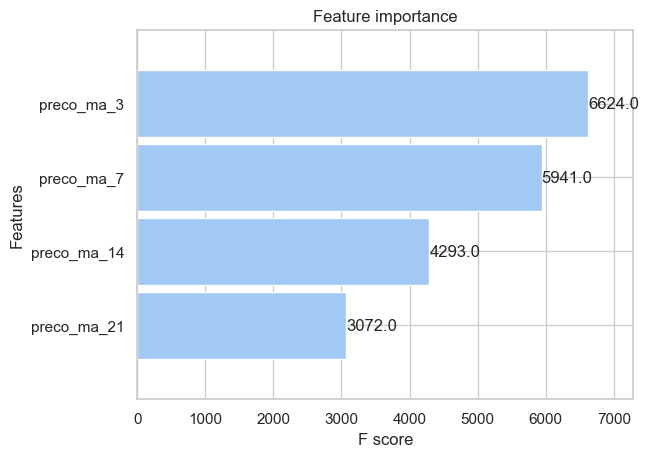

In [121]:
windows = [3, 7, 14, 21] #janelas para médias móveis em dias
dados_xgb_datas = calculate_moving_averages(dados_xgb_datas, 'preco', windows)

x = dados_xgb_datas.drop('preco', axis=1)
y = dados_xgb_datas['preco']

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, # dividindo 20% dos dados para teste
                                                    shuffle=False,
                                                    random_state=101) 


model = xgb.XGBRegressor(n_estimators=700,
                         eta = 0.01, # = learning_rate
                         max_depth = 5,
                         colsample_bytree = 0.7)

# model.fit(x_train, y_train, verbose = False)
model.fit(x_train, y_train, 
          eval_set=[(x_train, y_train), (x_test, y_test)],
          verbose = False)

prediction = model.predict(x_test)

_ = xgb.plot_importance(model, height=0.9)
print(cols)

O modelo usa os dados da média móvel 3D como ferature mais importante para treinar o modelo

In [122]:
df_train, df_test, df_predict = agg_datasets_train_test(dados_xgb_datas, y_train, y_test, prediction)

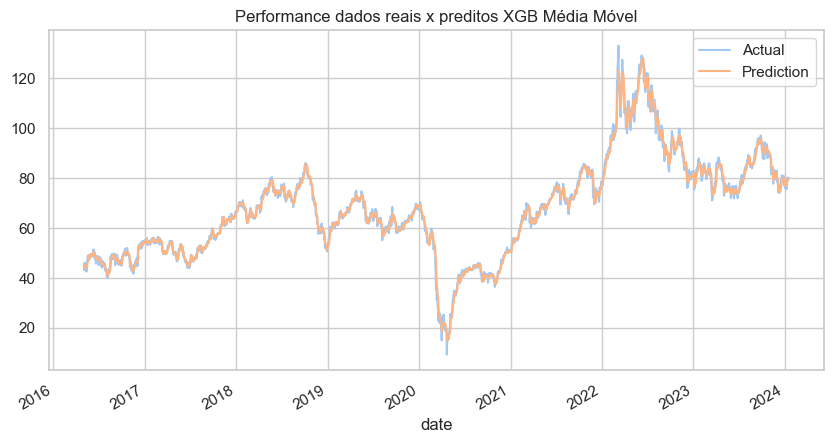

Métricas de avaliação XGB Média Móvel com GS:
	MAE: 1.1105042947081691
	MSE: 2.647740575153132
	MAPE: 0.02%
	R2 Score: 0.99%


In [123]:
plot_predictions_grid(index_test, y_test, prediction, "XGB Média Móvel")
evaluate_model(y_test, prediction, "XGB Média Móvel com GS")

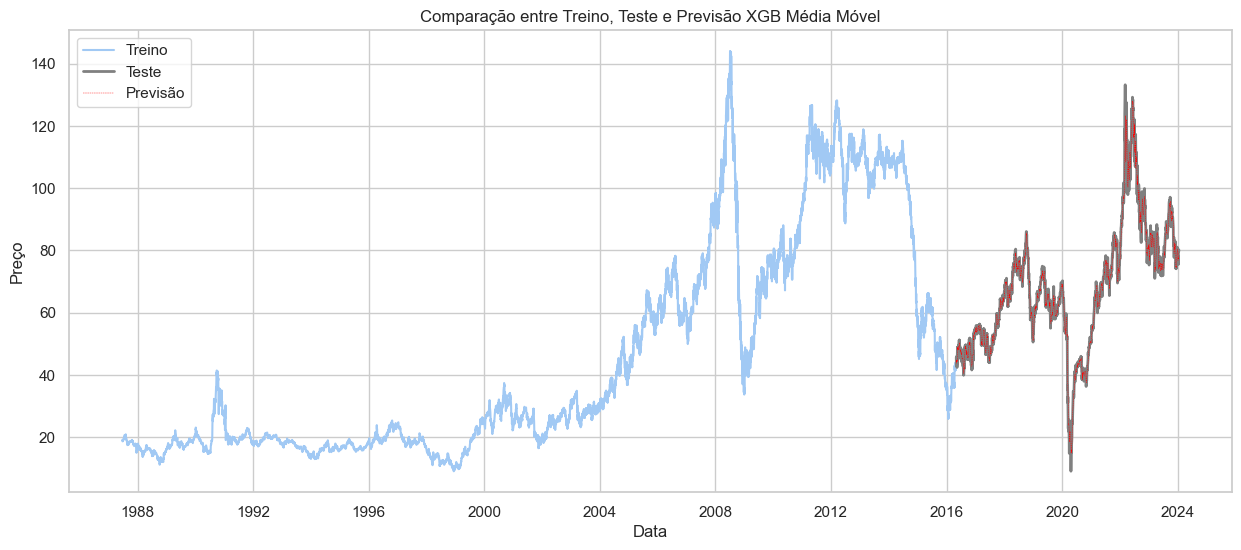

In [124]:
plot_prediction_test(df_train, df_test, df_predict, "XGB Média Móvel")

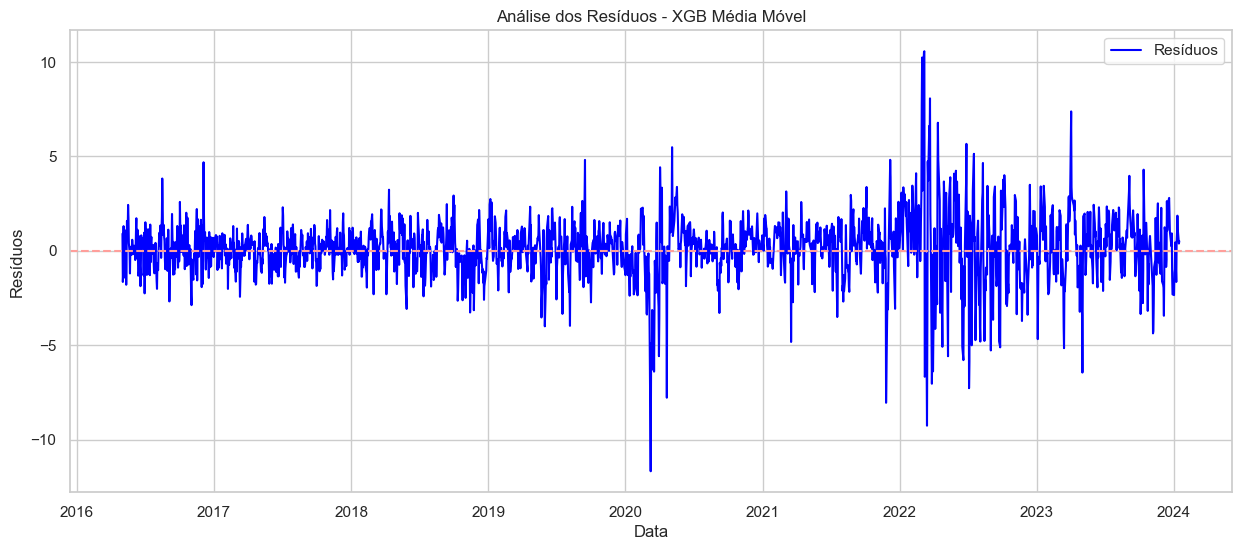

In [125]:
plot_residuos(y_test, prediction, "XGB Média Móvel")

# Adicionado Time features

In [126]:
dados_xgb_datas = dados_modelo.copy().set_index('data') # criação de uma cópia do dataframe para manipulação, deixando coluna "data como index
dados_xgb_datas = dados_xgb_datas.sort_values(by=["data"],ascending=True) # ordenando as datas em 
cols = list(dados_xgb_datas.columns.drop("preco"))

# criando features de datas
dados_xgb_datas = create_features(dados_xgb_datas)
windows = [3, 7, 14, 21] #janelas para médias móveis em dias
dados_xgb_datas = calculate_moving_averages(dados_xgb_datas, 'preco', windows)

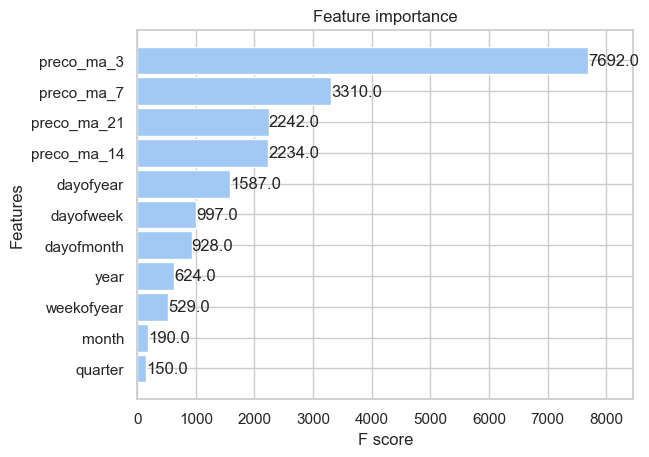

In [127]:
x = dados_xgb_datas.drop('preco', axis=1)
y = dados_xgb_datas['preco']

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, # dividindo 20% dos dados para teste
                                                    shuffle=False,
                                                    random_state=101) 


model = xgb.XGBRegressor(n_estimators=700,
                         eta = 0.01, # = learning_rate
                         max_depth = 5,
                         colsample_bytree = 0.7)

# model.fit(x_train, y_train, verbose = False)
model.fit(x_train, y_train, 
          eval_set=[(x_train, y_train), (x_test, y_test)],
          verbose = False)

prediction = model.predict(x_test)

_ = xgb.plot_importance(model, height=0.9)

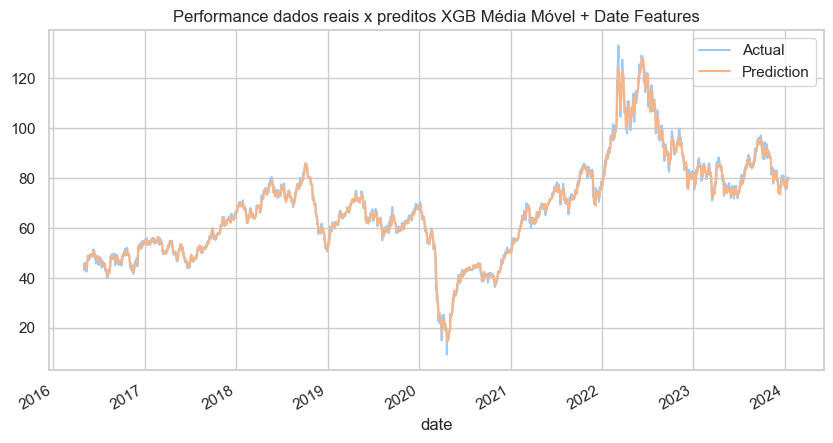

Métricas de avaliação XGB Média Móvel + Date Features com GS:
	MAE: 1.0727154718138878
	MSE: 2.3506717892573845
	MAPE: 0.02%
	R2 Score: 0.99%


In [128]:
df_train, df_test, df_predict = agg_datasets_train_test(dados_xgb_datas, y_train, y_test, prediction)
plot_predictions_grid(index_test, y_test, prediction, "XGB Média Móvel + Date Features")
evaluate_model(y_test, prediction, "XGB Média Móvel + Date Features com GS")

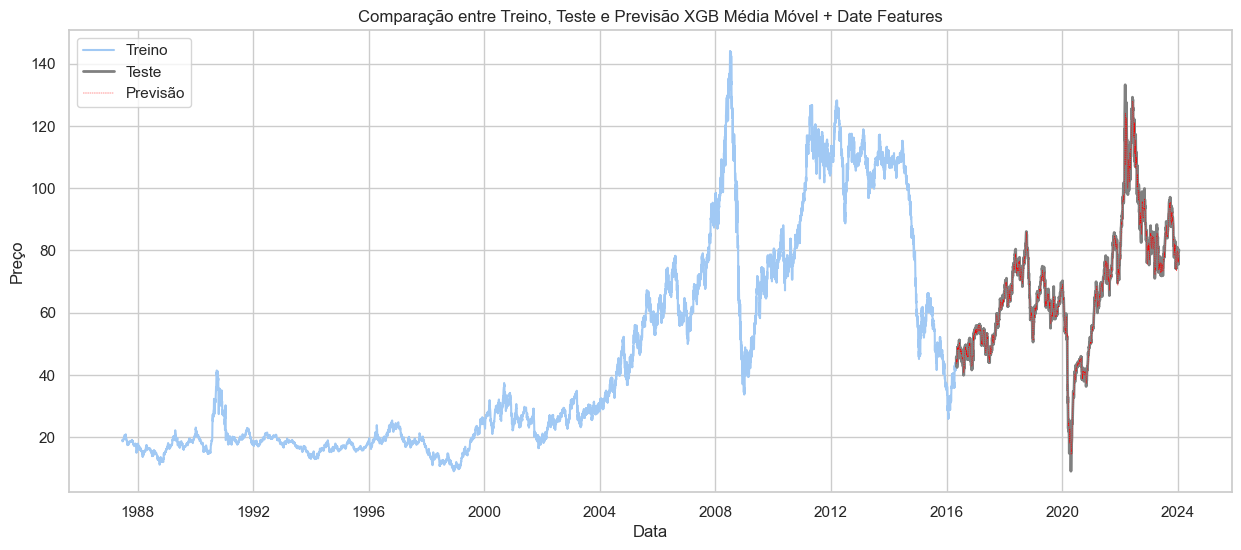

In [129]:
plot_prediction_test(df_train, df_test, df_predict, "XGB Média Móvel + Date Features")

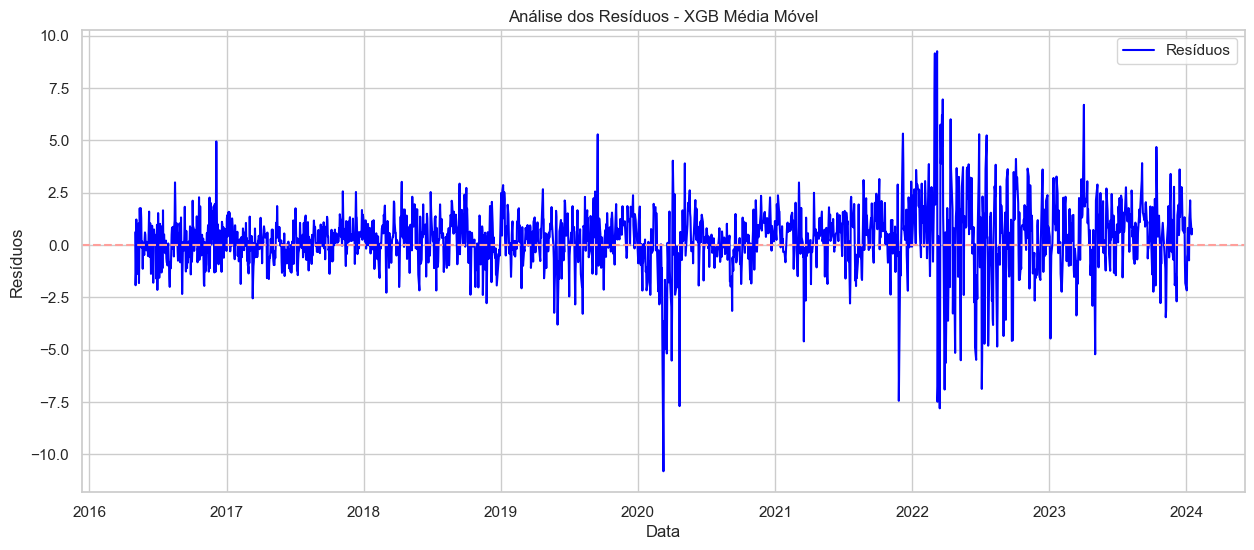

In [130]:
plot_residuos(y_test, prediction, "XGB Média Móvel")

## Validando e prevendo os próximos 7 dias

In [171]:
dados_xgb_datas = dados_xgb_datas.sort_values(by=["data"], ascending=True)

x = dados_xgb_datas.drop('preco', axis=1)
y = dados_xgb_datas['preco']

model = xgb.XGBRegressor(n_estimators=700,
                         eta = 0.01, # = learning_rate
                         max_depth = 5,
                         objective='reg:linear',
                         colsample_bytree = 0.7)

# model.fit(x_train, y_train, verbose = False)
model.fit(x, y, 
          eval_set=[(x, y)],
          verbose = 100)

[0]	validation_0-rmse:32.89818


[100]	validation_0-rmse:12.14498
[200]	validation_0-rmse:4.59715
[300]	validation_0-rmse:1.97919
[400]	validation_0-rmse:1.22004
[500]	validation_0-rmse:1.04571
[600]	validation_0-rmse:0.99461
[699]	validation_0-rmse:0.96955


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, num_parallel_tree=None, ...)

In [175]:
dados_xgb_valid = dados_xgb_datas.copy()
features = dados_xgb_datas.columns[1:]

future_7_days = pd.date_range(start=dados_xgb_valid.index[-1] + pd.Timedelta(days=1), periods=7, freq="1d")
future_df = pd.DataFrame(index = future_7_days)
future_df['isFuture'] = True
dados_xgb_valid['isFuture'] = False
df_and_future = pd.concat([dados_xgb_valid, future_df])
df_and_future = create_features(df_and_future)
df_and_future = calculate_moving_averages_all(df_and_future, 'preco', windows)
df_and_future.tail(15)

,preco,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,preco_ma_3,preco_ma_7,preco_ma_14,preco_ma_21,lag1,lag2,lag3,isFuture
2024-01-05,78.31,4,1,1,2024,5,5,1,77.093333,77.888571,78.790000,77.551905,77.69,80.23,76.84,False
2024-01-08,75.47,0,1,1,2024,8,8,2,76.523333,77.102857,78.692143,77.606190,NaN,NaN,78.89,False
2024-01-09,77.97,1,1,1,2024,9,9,2,77.250000,76.950000,78.626429,77.785238,76.24,80.23,79.82,False
2024-01-10,78.46,2,1,1,2024,10,10,2,77.300000,77.060000,78.529286,77.905238,77.18,80.97,81.10,False
2024-01-11,80.21,3,1,1,2024,11,11,2,78.880000,77.627143,78.465714,78.117619,75.79,79.04,80.73,False
2024-01-12,79.89,4,1,1,2024,12,12,2,79.520000,78.014286,78.405714,78.392857,78.31,77.69,80.23,False
2024-01-15,79.76,0,1,1,2024,15,15,3,79.953333,78.581429,78.372143,78.660476,75.47,NaN,NaN,False
2024-01-16,80.15,1,1,1,2024,16,16,3,79.933333,78.844286,78.366429,78.808095,77.97,76.24,80.23,False
2024-01-17,NaN,2,1,1,2024,17,17,3,79.933333,78.844286,78.366429,78.808095,NaN,NaN,NaN,True
2024-01-18,NaN,3,1,1,2024,18,18,3,79.933333,78.844286,78.366429,78.808095,NaN,NaN,NaN,True


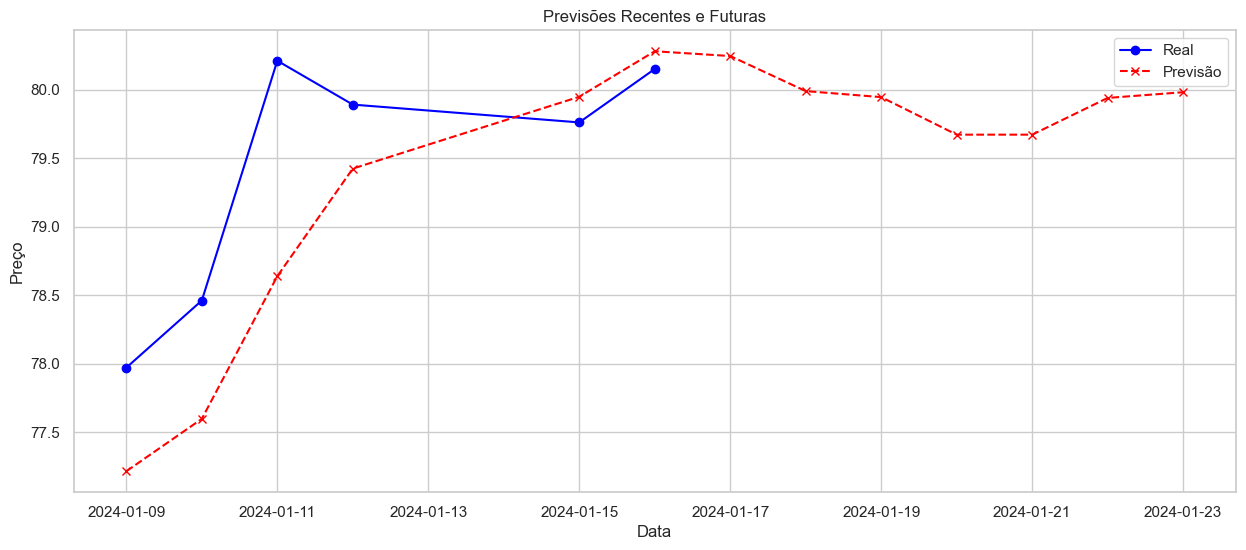

In [174]:
df_and_future_jan = df_and_future[df_and_future.index > '2024-01-08']
df_and_future_jan['pred'] = model.predict(df_and_future_jan[features])

# Plotando os resultados
plt.figure(figsize=(15, 6))

plt.plot(df_and_future_jan.index, df_and_future_jan['preco'], label='Real', marker='o', color='blue')
plt.plot(df_and_future_jan.index, df_and_future_jan['pred'], label='Previsão', linestyle='--', marker='x', color='red')
plt.title('Previsões Recentes e Futuras')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()


In [154]:
dados_preditos = df_and_future_jan[["preco", "pred"]]
dados_preditos["erro"] = df_and_future_jan['pred'] - df_and_future_jan['preco']
dados_preditos

,preco,pred,erro
2024-01-09,77.97,77.337410,-0.632590
2024-01-10,78.46,77.686699,-0.773301
2024-01-11,80.21,78.725060,-1.484940
2024-01-12,79.89,79.438309,-0.451691
2024-01-15,79.76,80.155853,0.395853
2024-01-16,80.15,80.154068,0.004068
2024-01-17,NaN,80.151558,NaN
2024-01-18,NaN,80.158508,NaN
2024-01-19,NaN,80.045013,NaN
2024-01-20,NaN,80.037926,NaN


## Otimização GridSearch e de Hiperparâmetros

In [199]:
# Avaliação GridSearch para XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=365)
model = xgb.XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0, 0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters) # , scoring='neg_mean_absolute_error'
grid_search.fit(x_train, y_train , verbose = False ) 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=365),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0, 0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

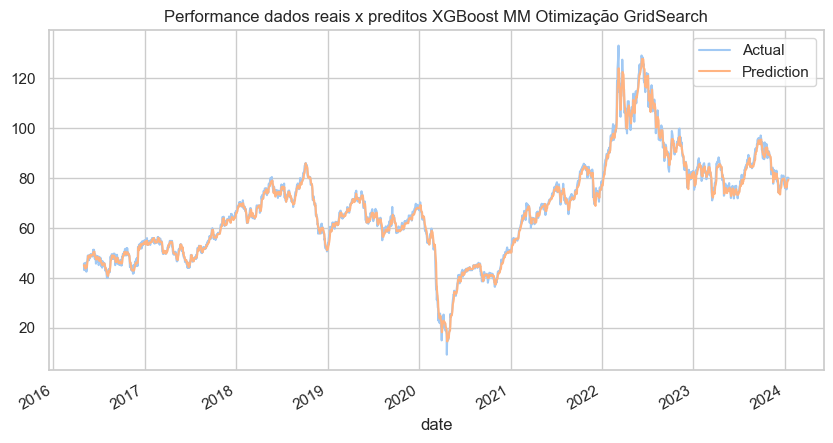

Métricas de avaliação XGBoost MM Otimização GridSearch:
	MAE: 1.0727154718138878
	MSE: 2.3506717892573845
	MAPE: 0.02%
	R2 Score: 0.99%
Melhores parâmetros:
	Melhores hiperparâmetros encontrados: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700}
	Melhor pontuação: 0.96%


In [200]:
# Evaluating GridSearch results
prediction = grid_search.predict(x_test)
plot_predictions_grid(index_test, y_test, prediction, "XGBoost MM Otimização GridSearch")
evaluate_model_grid(y_test, prediction, "XGBoost MM Otimização GridSearch")

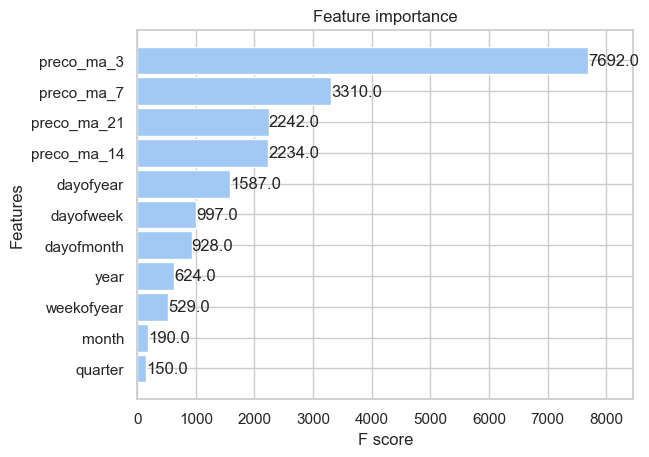

In [202]:
model = xgb.XGBRegressor(n_estimators=700,
                         eta = 0.01, # = learning_rate
                         max_depth = 5,
                         colsample_bytree = 0.7)

model.fit(x_train, y_train, 
          eval_set=[(x_train, y_train), (x_test, y_test)],
          verbose = False)

prediction = model.predict(x_test)
_ = xgb.plot_importance(model, height=0.9)

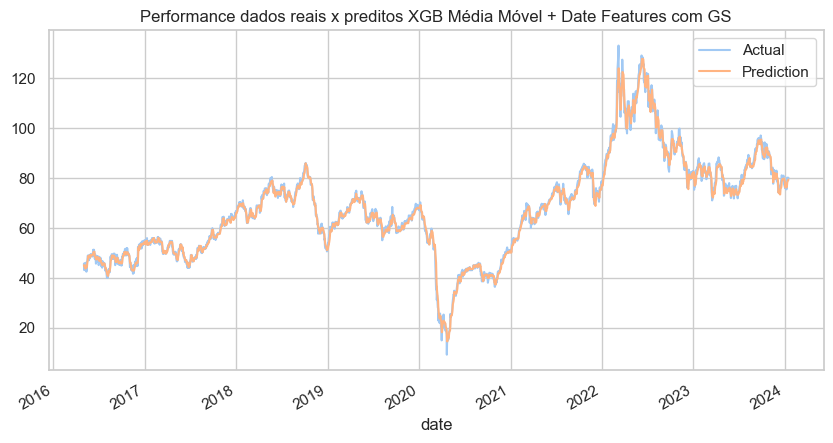

Métricas de avaliação XGB Média Móvel + Date Features com GS:
	MAE: 1.0727154718138878
	MSE: 2.3506717892573845
	MAPE: 0.02%
	R2 Score: 0.99%


In [203]:
df_train, df_test, df_predict = agg_datasets_train_test(dados_xgb_datas, y_train, y_test, prediction)
plot_predictions_grid(index_test, y_test, prediction, "XGB Média Móvel + Date Features com GS")
evaluate_model(y_test, prediction, "XGB Média Móvel + Date Features com GS")

## Validação de métricas entre modelos

In [170]:
df_results = pd.DataFrame(evaluation_results).T # Convertendo o dicionário inicial em um DataFrame
df_results.head()

,XGB Média Móvel com GS,XGB Média Móvel + Date Features com GS,XGB Com lags
MAE,1.110504,1.072715,1.032816
MSE,2.647741,2.350672,2.208825
MAPE,0.017993,0.017185,0.016603
R2,0.992884,0.993683,0.994064
